In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import ray
import time
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import torch
from torch import nn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None


def get_position_delta(row):
    return row.s / 10 * row.dir_vec


def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
# Prep data
prog_start = time.time()
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
           'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived',
           'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
           'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
           'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
           'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
           'offense_a_to_end', 'defense_p_play', 'defense_p_presnap', 'defense_p_to_throw', 'defense_p_to_arrived',
           'defense_p_to_end', 'defense_m_play', 'defense_m_presnap', 'defense_m_to_throw', 'defense_m_to_arrived',
           'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived',
           'defense_v_to_end', 'defense_a_play', 'defense_a_presnap', 'defense_a_to_throw', 'defense_a_to_arrived',
           'defense_a_to_end', 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE',
           'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group',
           'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group',
           'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

#tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
#tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [5]:
play_df.shape

(6053, 65)

In [6]:
253/(32*16)

0.494140625

In [7]:
play_df.describe()

,gameId,playId,offense_h_play,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_h_to_end,defense_h_play,defense_h_presnap,defense_h_to_throw,...,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes
count,6.053000e+03,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,...,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000
mean,2.018107e+09,2175.908971,4.891404,0.212278,4.670505,3.961326,4.315888,5.217516,1.288699,4.502479,...,0.389724,0.871138,0.324798,0.224021,0.146043,0.317033,0.175450,0.268627,0.019164,4.579052
std,1.139088e+04,1256.228321,0.471664,0.365859,0.589313,0.404033,0.665939,0.465863,0.754770,0.653425,...,0.651101,0.914874,0.650569,0.522499,0.378036,0.560399,0.385561,0.508879,0.137113,0.652341
min,2.018091e+09,51.000000,2.665374,-0.000000,1.159672,2.218546,1.251629,3.235330,-0.000000,0.514318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.018100e+09,1113.000000,4.590837,0.000000,4.375753,3.693902,3.846840,4.929675,0.735127,4.126828,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,2.018110e+09,2186.000000,4.903628,0.000000,4.734094,3.959441,4.349947,5.257174,1.242202,4.582293,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,2.018120e+09,3240.000000,5.218962,0.308506,5.051784,4.231135,4.812020,5.542995,1.776322,4.963587,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000
max,2.018123e+09,5637.000000,6.601220,3.171627,6.179106,5.573548,6.514224,6.663877,3.824150,6.128508,...,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,2.000000,3.000000,1.000000,5.000000


In [8]:
def draw_prob_density(x_series, y_series, x_bins, y_bins, ax, xlab=None, ylab=None, cbar=True):
    dims = {'x': x_series.max() * 1.00001, 'y': y_series.max() * 1.00001}

    bins = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    rows = min(len(y_series), len(x_series))

    for row in range(rows):
        i = int(x_series.iloc[row] / dims['x'] * x_bins)
        j = int(y_series.iloc[row] / dims['y'] * y_bins)
        bins[j][i] += 1

    smoothing_grid = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    for i in range(x_bins):
        for j in range(y_bins):
            sum = 0
            count = 0
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < x_bins and 0 <= j + y < y_bins:
                        sum += bins[j + y][i + x]
                        count += 1
            smoothing_grid[j][i] = sum / count

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if cbar:
        c = ax.pcolor(smoothing_grid, cmap='jet')
        plt.colorbar(c, ax=ax)
    else:
        ax.pcolor(smoothing_grid, cmap='jet')

In [39]:
fig_height = 3
output_folder = './d30_results/'

p_axis = r'$P_{group}$'
m_axis = r'$M_{group}$'
v_axis = r'$V_{group}$ (yd/s)'
h_axis = r'$H_{group}$ (bits)'
a_axis = r'$A_{group}$ ($yd^2$)'

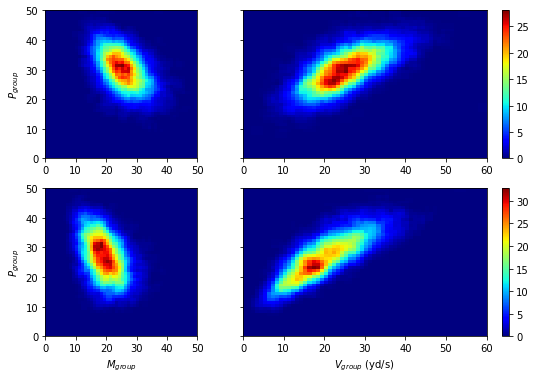

In [38]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(3*fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_m_play'], play_df['offense_p_play'], 50, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_v_play'], play_df['offense_p_play'], 60, 50, axs[0][1])
draw_prob_density(play_df['defense_m_play'], play_df['defense_p_play'], 50, 50, axs[1][0], m_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_v_play'], play_df['defense_p_play'], 60, 50, axs[1][1], v_axis)

#fig.suptitle(r'FIGURE 1: Density plots for polarisation, angular momentum and mean group velocity')
plt.savefig(f'{output_folder}figure1.png')

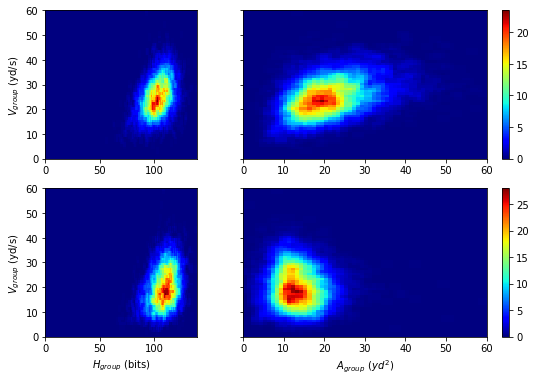

In [40]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(3 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_h_play'], play_df['offense_v_play'], 140, 60, axs[0][0], ylab=r'$V_{group}$ (yd/s)', cbar=False)
draw_prob_density(play_df['offense_a_play'], play_df['offense_v_play'], 60, 60, axs[0][1],)
draw_prob_density(play_df['defense_h_play'], play_df['defense_v_play'], 140, 60, axs[1][0], h_axis, v_axis, cbar=False)
draw_prob_density(play_df['defense_a_play'], play_df['defense_v_play'], 60, 60, axs[1][1], a_axis)

#fig.suptitle('FIGURE 2: V_Group vs H_group and A_group')
plt.savefig(f'{output_folder}figure2.png')

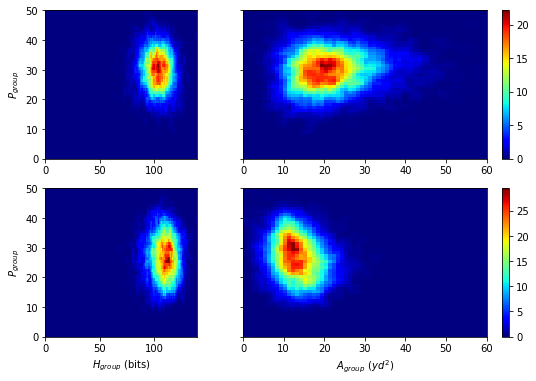

In [42]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(3 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(play_df['offense_h_play'], play_df['offense_p_play'], 140, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_a_play'], play_df['offense_p_play'], 60, 50, axs[0][1])
draw_prob_density(play_df['defense_h_play'], play_df['defense_p_play'], 140, 50, axs[1][0], h_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_a_play'], play_df['defense_p_play'], 60, 50, axs[1][1], a_axis)

#fig.suptitle('FIGURE 3: P_group vs H_group and A_group')
plt.savefig(f'{output_folder}figure3.png')

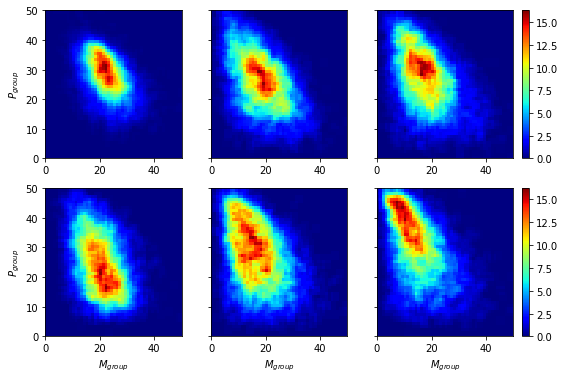

In [43]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(3 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 1, 1.25]})

draw_prob_density(play_df['offense_m_to_throw'], play_df['offense_p_to_throw'], 50, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_m_to_arrived'], play_df['offense_p_to_arrived'], 50, 50, axs[0][1], cbar=False)
draw_prob_density(play_df['offense_m_to_end'], play_df['offense_p_to_end'], 50, 50, axs[0][2])
draw_prob_density(play_df['defense_m_to_throw'], play_df['defense_p_to_throw'], 50, 50, axs[1][0], m_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_m_to_arrived'], play_df['defense_p_to_arrived'], 50, 50, axs[1][1], m_axis, cbar=False)
draw_prob_density(play_df['defense_m_to_end'], play_df['defense_p_to_end'], 50, 50, axs[1][2], m_axis)

#fig.suptitle('FIGURE 4: P_Group vs M_Group (Stages of Play)')
plt.savefig(f'{output_folder}figure4.png')

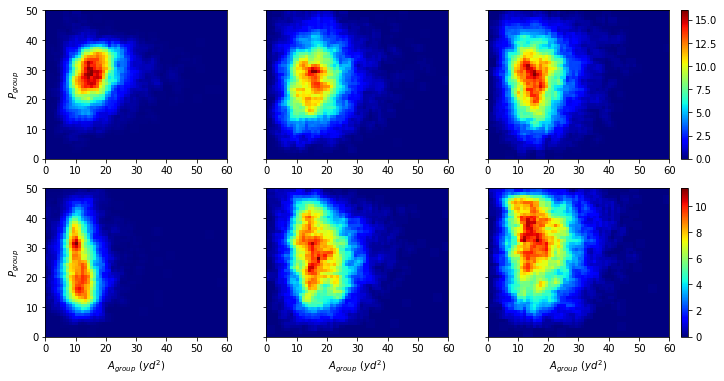

In [44]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(4 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 1, 1.25]})

draw_prob_density(play_df['offense_a_to_throw'], play_df['offense_p_to_throw'], 60, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_a_to_arrived'], play_df['offense_p_to_arrived'], 60, 50, axs[0][1], cbar=False)
draw_prob_density(play_df['offense_a_to_end'], play_df['offense_p_to_end'], 60, 50, axs[0][2])
draw_prob_density(play_df['defense_a_to_throw'], play_df['defense_p_to_throw'], 60, 50, axs[1][0], a_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_a_to_arrived'], play_df['defense_p_to_arrived'], 60, 50, axs[1][1], a_axis, cbar=False)
draw_prob_density(play_df['defense_a_to_end'], play_df['defense_p_to_end'], 60, 50, axs[1][2], a_axis)

#fig.suptitle('FIGURE 5: P_group vs A_group (Stages of Play)')
plt.savefig(f'{output_folder}figure5.png')

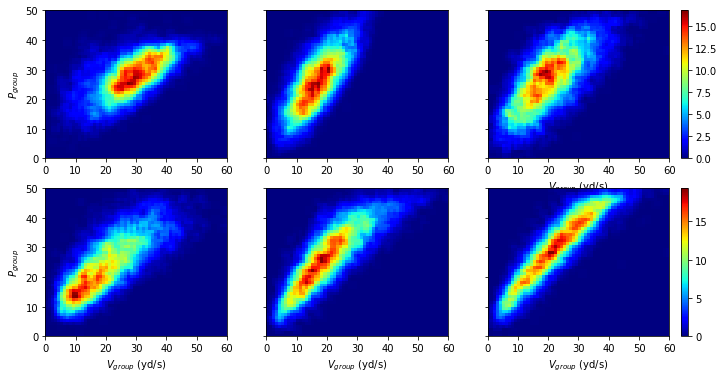

In [45]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(4 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 1, 1.25]})

draw_prob_density(play_df['offense_v_to_throw'], play_df['offense_p_to_throw'], 60, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_v_to_arrived'], play_df['offense_p_to_arrived'], 60, 50, axs[0][1], cbar=False)
draw_prob_density(play_df['offense_v_to_end'], play_df['offense_p_to_end'], 60, 50, axs[0][2], v_axis)

draw_prob_density(play_df['defense_v_to_throw'], play_df['defense_p_to_throw'], 60, 50, axs[1][0], v_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_v_to_arrived'], play_df['defense_p_to_arrived'], 60, 50, axs[1][1], v_axis, cbar=False)
draw_prob_density(play_df['defense_v_to_end'], play_df['defense_p_to_end'], 60, 50, axs[1][2], v_axis)

#fig.suptitle('FIGURE 6: P_group vs V_group (Stages of Play)')
plt.savefig(f'{output_folder}figure6.png')

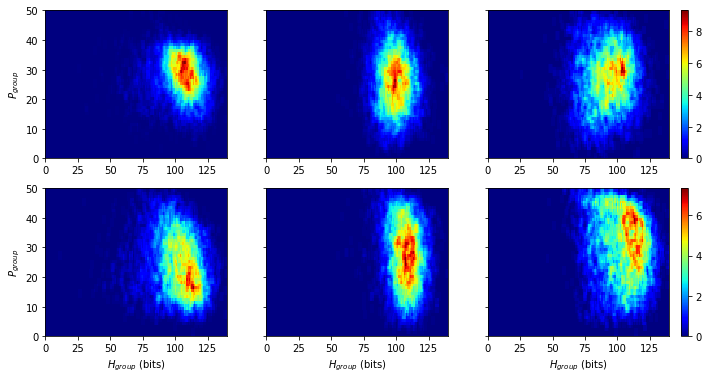

In [46]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(4 * fig_height, fig_height * 2), gridspec_kw={'width_ratios': [1, 1, 1.25]})

draw_prob_density(play_df['offense_h_to_throw'], play_df['offense_p_to_throw'], 140, 50, axs[0][0], ylab=p_axis, cbar=False)
draw_prob_density(play_df['offense_h_to_arrived'], play_df['offense_p_to_arrived'], 140, 50, axs[0][1], cbar=False)
draw_prob_density(play_df['offense_h_to_end'], play_df['offense_p_to_end'], 140, 50, axs[0][2])

draw_prob_density(play_df['defense_h_to_throw'], play_df['defense_p_to_throw'], 140, 50, axs[1][0], h_axis, p_axis, cbar=False)
draw_prob_density(play_df['defense_h_to_arrived'], play_df['defense_p_to_arrived'], 140, 50, axs[1][1], h_axis, cbar=False)
draw_prob_density(play_df['defense_h_to_end'], play_df['defense_p_to_end'], 140, 50, axs[1][2], h_axis)

#fig.suptitle('FIGURE 7: P_group vs H_group (Stages of Play)')
plt.savefig(f'{output_folder}figure7.png')

In [17]:
def get_o_transition_state(row):
    if row.offense_p_play > 0.65 and row.offense_m_play < 0.35:
        return 'polar'
    elif row.offense_p_play < 0.35 and row.offense_m_play < 0.35:
        return 'swarm'
    elif row.offense_p_play < 0.35 and row.offense_m_play > 0.65:
        return 'milling'
    else:
        return 'transitional'

def get_d_transition_state(row):
    if row.defense_p_play > 0.65 and row.defense_m_play < 0.35:
        return 'polar'
    elif row.defense_p_play < 0.35 and row.defense_m_play < 0.35:
        return 'swarm'
    elif row.defense_p_play < 0.35 and row.defense_m_play > 0.65:
        return 'milling'
    else:
        return 'transitional'

In [18]:
play_df['o_state'] = play_df.apply(get_o_transition_state, axis=1)
play_df['d_state'] = play_df.apply(get_d_transition_state, axis=1)

In [19]:
print(play_df[(play_df['o_state'] == 'polar')].shape)
print(play_df[(play_df['o_state'] == 'swarm')].shape)
print(play_df[(play_df['o_state'] == 'milling')].shape)
print(play_df[(play_df['o_state'] == 'transitional')].shape)
print(play_df[(play_df['d_state'] == 'polar')].shape)
print(play_df[(play_df['d_state'] == 'swarm')].shape)
print(play_df[(play_df['d_state'] == 'milling')].shape)
print(play_df[(play_df['d_state'] == 'transitional')].shape)

(403, 67)
(241, 67)
(0, 67)
(5409, 67)
(610, 67)
(672, 67)
(1, 67)
(4770, 67)


In [20]:
o_states = {'polar': play_df[(play_df['o_state'] == 'polar')].shape[0],
            'swarm': play_df[(play_df['o_state'] == 'swarm')].shape[0],
            'milling': play_df[(play_df['o_state'] == 'milling')].shape[0],
            'transitional': play_df[(play_df['o_state'] == 'transitional')].shape[0]}

d_states = {'polar': play_df[(play_df['d_state'] == 'polar')].shape[0],
            'swarm': play_df[(play_df['d_state'] == 'swarm')].shape[0],
            'milling': play_df[(play_df['d_state'] == 'milling')].shape[0],
            'transitional': play_df[(play_df['d_state'] == 'transitional')].shape[0]}

In [21]:
d_states

{'polar': 610, 'swarm': 672, 'milling': 1, 'transitional': 4770}

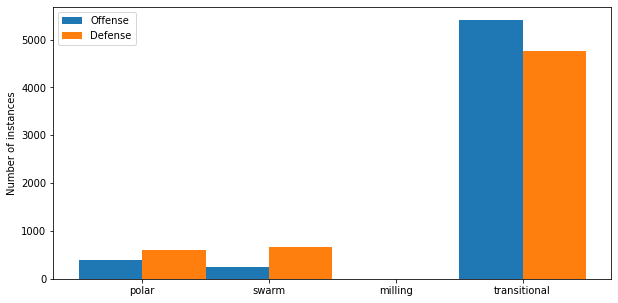

In [51]:
ind = np.arange(len(o_states))
width = 0.5

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(ind - width / 2, o_states.values(), width, label='Offense')
ax.bar(ind + width / 2, d_states.values(), width, label='Defense')
ax.set_ylabel('Number of instances')
#ax.set_title('Distribution of offensive and defensive collective states')
ax.set_xticks(ind)
ax.set_xticklabels(o_states.keys())
ax.legend(loc='upper left')

plt.savefig(f'{output_folder}figure8.png')

In [23]:
print(o_states)
print(d_states)

{'polar': 403, 'swarm': 241, 'milling': 0, 'transitional': 5409}
{'polar': 610, 'swarm': 672, 'milling': 1, 'transitional': 4770}
